## This notebook may be used to reproduce Fig S5 in the Supplementary Material.

### Parameter values that need to be changed to derive the different subfigures are mentioned in comments as appropriate. Note that nonlinear and linear versions of the interneuronal inhibition model can be chosen.

In [1]:
import ipyparallel as ipp
clients = ipp.Client()

In [2]:
clients.ids

[0, 1, 2, 3]

In [3]:
dview = clients.direct_view()

In [4]:
with dview.sync_imports():
    import numpy as np
    from math import exp,sqrt,log
    import numpy.random
%px np = numpy
%px rand = numpy.random

importing numpy on engine(s)
importing exp,sqrt,log from math on engine(s)
importing numpy.random on engine(s)


In [24]:
def Sim_Anim_Beh(trials,randSeed,rin):
    
    rand.seed(randSeed)
    
    ##############################################################################################
    # Runge_Kutta 4th-order
    ##############################################################################################
    def rk4(F,t,y,ht):
        K0 = ht*F(t,y,dfct)
        K1 = ht*F(t + ht/2.0, y + K0/2.0,dfct)
        K2 = ht*F(t + ht/2.0, y + K1/2.0,dfct)
        K3 = ht*F(t + ht, y + K2,dfct)
        return (K0 + 2.0*K1 + 2.0*K2 + K3)/6.0

    ####################################################
    # Predictor-corrector integration routine: Heun for stochastic differential equations
    ####################################################
    # time t
    # time step ht
    # number of equations (=dimensionality) n
    # random numbers xi
    # deterministic and stochastic contributons Fdet and Frand
    def Heun(Fdet, Frand,t,y,ht):
        fd1 = np.zeros(3)
        fd2 = np.zeros(3)
        fr = np.zeros(3)
        yt = np.zeros(3)
        fd1 = Fdet(t,y,dfct)
        fr = Frand()
        yt = y + ht*fd1 + fr*sqrt(ht)
        fd2 = Fdet(t+ht,yt,dfct)
        ht2 = ht/2.0
        return ht2*(fd1+fd2) + fr*sqrt(ht)
    
    #activation function
    def actfct(z,g,b):
        return 1/(1+exp(-g*(z-b)))

    #differential equations motivations
    #determnistic part
    
    #nonlinear model
    def Fdet(t,y,dfct):
        Fdet = np.zeros(3)
        Fdet[0] = -k*y[0] + beta*r*actfct(y[0],g1,b1) - beta*actfct(y[2],g2,b2) + q*dfct[0]
        Fdet[1] = -k*y[1] + beta*r*actfct(y[1],g1,b1) - beta*actfct(y[2],g2,b2) + q*dfct[1]
        Fdet[2] = -kinh*y[2] + w_exc*(actfct(y[0],g1,b1) + actfct(y[1],g1,b1))
        return Fdet
    '''  
    #linear model
    def Fdet(t,y,dfct):
        Fdet = np.zeros(3)
        Fdet[0] = (r*beta*g1/4-k)*y[0] - beta*g2/4*y[2] + q*dfct[0] + phi
        Fdet[1] = (r*beta*g1/4-k)*y[1] - beta*g2/4*y[2] + q*dfct[1] + phi
        Fdet[2] = -kinh*y[2] + w_exc*(1 - g1*b1/2 + g1/4*(y[0] + y[1]))
        return Fdet
    '''
    def FrandDet():
        FrandDet = np.zeros(3)
        return FrandDet
    
    
    
    # stochastic part of RHS   
    def Frand():
        Frand = np.zeros(3)
        xRand0 = rand.normal(0,1)
        xRand1 = rand.normal(0,1)
        Frand[0] = sigma*xRand0
        Frand[1] = sigma*xRand1
        Frand[2] = 0
        return Frand
    
    # model parameters
    k = 0.8 # leak excitatory unit
    kinh = 0.8 # leak inhibitory unit
    w_exc = 3 # excitation strength inhibitory unit
    q = 0.1 # frequency of integration
    g1 = 10 # gain excitation function
    g2 = 10 # gain inhibition function
    b1 = 0.5 # midpoint excitation function
    b2 = 0.5 # midpoint inhibition function
    beta = 3 #3 # inhibition strength
    r = rin
    
    #r = 1.0
    
    #r = 1.3703 #2 # r = ratio of excitation/inhibition strengths
    #phi for linear model
    phi = 0.5*beta*(r*(1 - g1*b1/2) - (1 - g2*b2/2))
    
    # geometric distribution for bout times
    # probability of interruption
    # calculation of maximum terminal bout time 'bout_max_99' including 99 percent of all values
    lam_interrupt = 0.05
    bout_max_99 = int(log(0.01)/log(1-lam_interrupt)) + 1
    
    eps_offset = 1e-9
    decay = 0.15 #0.15
    
    d01 = 8.1
    d02 = np.sqrt(2*7.5*7.5-d01**2) 
    #dfct_start = 7.5
    t = 0.0  #start time
    tend = 200  #terminal time 
    y = np.array([0.0, 0.0, 0.0])  #initial conditions
    dfct = np.array([d01, d02])
    ht = 0.005  #time step
    sigma = 0
    time1 = []  
    Ysol1 = []
    time1.append(t)
    Ysol1.append(y)

    while t <= tend:
        #ht = min(ht,tend-t)
        #y = y + Heun(Fdet,FrandDet,t,y,%%html)
        y = y + rk4(Fdet,t,y,ht)
        for ii in range(len(y)):
            y[ii] = max(0, y[ii])
        t = t + ht
        time1.append(t)
        Ysol1.append(y)
    
    y_init = y
    dfct_init = dfct
        
    Ep_sum_av = 0
    time2_list = []
    Ysol2_list = []
    Deficit_list = []
    
    for nn in range(trials):
        # select tau_dist = 0.05 for Figs S5(a)-S5(d)
        # select tau_dist = 4.0 for Figs S5(e)-S5(h)
        tau_dist = 0.05 #time to overcome distance between food and water sources
        
        t = 0.0
        tau = tau_dist/2.0 #initially animal is in between the two sources
        tchange = 0.0
        sigma = 0.01
        nfood = 2
        nwater = 2

        Tep = []
        Ep = []
        Ep_sum = 0
        time2 = []  
        Ysol2 = []
        Deficit = []
        time2.append(t)
        Ysol2.append(y)
        Deficit.append(dfct)
        #Tbout_max = 4 
        Tbout_max = bout_max_99
        #ht = 0.005
        
        tend = Tbout_max + 1
        while t <= tend:
            #ht = min(ht,tend-t)
            for kk in range(1,Tbout_max+1):
                if t > kk-ht/2 and t < kk+ht/2:
                    Tep.append(int(t+ht))
                    penalty = dfct[0]*dfct[0] + dfct[1]*dfct[1]
                    Ep.append(penalty*lam_interrupt*pow(1-lam_interrupt,int(t+ht)-1))
            
            
            if y[0] == y[1]:
                randNr = rand.uniform(0,1)
                if randNr < 0.5:
                    y[0] = y[0] + eps_offset
                else:
                    y[1] = y[1] + eps_offset
                    
            dely1 = y[0] - y[1]
            
            if y[0] > y[1]:
                if t > tchange + tau: 
                    dfct[0] = dfct[0] - decay*ht  
                    nfood = 1
                    nwater = 0
            #else:
            elif y[1] > y[0]:
                if t > tchange + tau: 
                    dfct[1] = dfct[1] - decay*ht 
                    nwater = 1
                    nfood = 0   
                    
                    
            #if dfct[0] < 0:
            #    dfct[0] = 0
            #if dfct[1] < 0:
            #    dfct[1] = 0
            #if dfct[0] <= 0 or dfct[1] <= 0:
            #    break
            
            for jj in range(len(dfct)):
                dfct[jj] = max(0, dfct[jj])
            
            y = y + Heun(Fdet,Frand,t,y,ht)
            for ii in range(len(y)):
                y[ii] = max(0, y[ii])
                
            if y[0] == y[1]:
                randNr = rand.uniform(0,1)
                if randNr < 0.5:
                    y[0] = y[0] + eps_offset
                else:
                    y[1] = y[1] + eps_offset
                    
            dely2 = y[0] - y[1]
            
            if np.sign(dely1)*np.sign(dely2) < 0:
            #if dely1*dely2 < 0:
            #if (dely1 > 1e-6 and dely2 < -1e-6) or (dely1 < -1e-6 and dely2 > 1e-6):
                tchange_old = tchange
                tchange = t
                if nfood == 1 or nwater == 1:
                    tau = tau_dist
                    nfood = 0
                    nwater = 0
                else:
                    tau = tau_dist-tau + tchange-tchange_old
            
            t = t + ht
            dfct = np.array([dfct[0], dfct[1]])
            Deficit.append(dfct)
            time2.append(t)
            Ysol2.append(y)
        
        time2_list = time2_list + time2
        Ysol2_list = Ysol2_list + Ysol2
        Deficit_list = Deficit_list + Deficit
        Ep_sum = np.sum(Ep)
        Ep_sum_av += Ep_sum/trials
        y = y_init
        dfct = dfct_init
    
    time2_av = []
    Ysol2_av = []
    Deficit_av = []
    for kk in range(len(time2)):
        time2_av.append(np.sum(time2_list[kk::len(time2)])/trials)
        Ysol2_av.append(sum(Ysol2_list[kk::len(time2)])/trials)
        Deficit_av.append(sum(Deficit_list[kk::len(time2)])/trials)
    return Ep_sum_av,time1,Ysol1,time2_av,Ysol2_av,Deficit_av,tau_dist 

In [25]:
rlist = [0.5,1,1.5,2]

import timeit
time_start = timeit.default_timer()
nr_engines = len(clients.ids)
randSeedList = [(jj+1)*1928374 for jj in range(nr_engines)]
nr_trials_tot = 4
nr_trials_per_engine = int(nr_trials_tot/nr_engines)
results = dview.map_sync(Sim_Anim_Beh, [nr_trials_per_engine]*nr_engines, randSeedList, rlist)
time_stop = timeit.default_timer()
print('elapsed time =',time_stop - time_start,'seconds')

elapsed time = 8.568986506958026 seconds


In [26]:
time1 = results[0][1]  
Ysol1 = results[0][2]
time2 = results[0][3]
Ep_sum_av = 0
Ysol2 = [0]*len(time2)
Deficit = [0]*len(time2)
for kk in range(nr_engines):
    Ep_sum_av += results[kk][0]/nr_engines
for jj in range(len(time2)):
    for kk in range(nr_engines):
        Ysol2[jj] += results[kk][4][jj]/nr_engines
        Deficit[jj] += results[kk][5][jj]/nr_engines
        

In [27]:
print('initial penalty = ',2*7.5*7.5)
print('Expected penalty =',Ep_sum_av)
print('penalty ratio = ', Ep_sum_av/(2*7.5*7.5))
print(results[0][0]/(2*7.5*7.5))
print(results[1][0]/(2*7.5*7.5))
print(results[2][0]/(2*7.5*7.5))
print(results[3][0]/(2*7.5*7.5))

initial penalty =  112.5
Expected penalty = 77.5766714263
penalty ratio =  0.689570412679
0.675881446164
0.686871269477
0.710524882157
0.685004052917


In [28]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

<IPython.core.display.Javascript object>


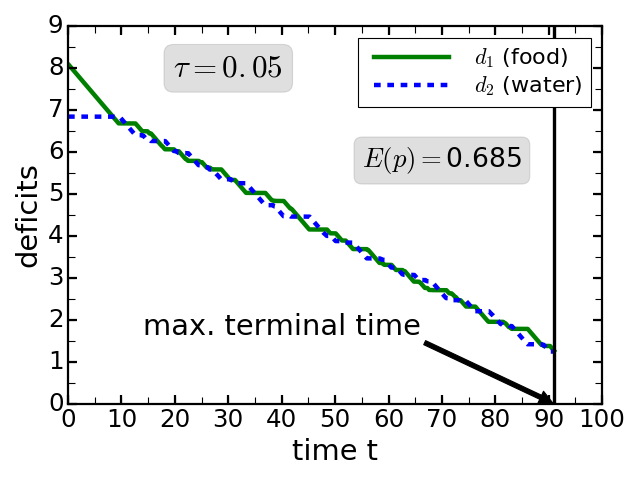

In [29]:
# the option 'choose_engine = ' relates to the subfigures in Fig S5
# choose_engine = 0 -> Fig S5(a) (tau=0.05)  or   Fig S5(e) (tau=4)
# choose_engine = 1 -> Fig S5(b) (tau=0.05)  or   Fig S5(f) (tau=4)
# choose_engine = 2 -> Fig S5(c) (tau=0.05)  or   Fig S5(g) (tau=4)
# choose_engine = 0 -> Fig S5(d) (tau=0.05)  or   Fig S5(h) (tau=4)
choose_engine = 3

fig=plt.figure()
plt.plot(np.asarray(time2),np.asarray(results[choose_engine][5])[:,0],c = 'g',lw = 4, label=r'$d_1$ (food)')
plt.plot(np.asarray(time2),np.asarray(results[choose_engine][5])[:,1],c = 'b',lw = 4, ls='--', label=r'$d_2$ (water)')
#plt.plot(np.asarray(time2),np.asarray(Deficit)[:,0],c = 'b',lw = 3.5)
#plt.plot(np.asarray(time2),np.asarray(Deficit)[:,1],c = 'r',lw = 3.5)
#results[choose_engine][0]/(2*7.5*7.5)

ax = plt.axes()

# give tau_dist value chosen above
# either 0.05  or  4.0
tauVal=0.05
bbox_props = dict(boxstyle="round", fc="grey", ec="0.5", alpha=0.25)
ax.text(30, 8, r"$\tau =$"+'$'+str(tauVal)+'$', ha="center", va="center", size=28,
        bbox=bbox_props)
Ep_value = np.round(results[choose_engine][0]/(2*7.5*7.5), 3)
bbox_props = dict(boxstyle="round", fc="grey", ec="0.5", alpha=0.25)
ax.text(70, 5.8, r"$E(p)=$"+str(Ep_value), ha="center", va="center", size=24,
        bbox=bbox_props)

plt.xlabel(r'time t', fontsize=26)
plt.ylabel(r'deficits', fontsize=26)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(22) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
#plt.text(61, 4.62, r'max. terminal', fontsize=24)
#plt.text(82, 4.4, r'time', fontsize=24)
#ax.arrow(91, 4.3, 0, -2.22, head_width=2, head_length=0.07, fc='k', ec='k',lw=2.5)
#plt.tick_params(labelsize=14)

plt.plot((91, 91), (0, 9), c = 'k', ls = '-', lw = 3)

plt.xlim(0,100)
plt.ylim(0,9)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params('both', length=8, width=2, which='major')
ax.tick_params('both', length=6, width=1, which='minor')

ax.annotate(r'max. terminal time', xy=(91, 0), xytext=(40, 1.5), fontsize=26,
            arrowprops=dict(facecolor='k', edgecolor='k', shrink=0.01),
            horizontalalignment='center', verticalalignment='bottom')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)


plt.legend(bbox_to_anchor=(1, 1), frameon=True, handlelength=4, borderpad=0.4, labelspacing=0.2, fontsize=20)
plt.tight_layout();